In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from copy import deepcopy
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D 

**Easy21 rules:**

- The game is played with an infinite deck of cards (i.e. cards are sampled
with replacement)


- Each draw from the deck results in a value between 1 and 10 (uniformly
distributed) with a colour of red (probability 1/3) or black (probability
2/3).


- There are no aces or picture (face) cards in this game


- At the start of the game both the player and the dealer draw one black
card (fully observed)


- Each turn the player may either **stick** or **hit**


- If the player hits then he draws another card from the deck


- If the player sticks he receives no further cards


- The values of the player’s cards are added (black cards) or subtracted (red
cards)


- If the player’s sum exceeds 21, or becomes less than 1, then he “goes
bust” and loses the game (reward -1)


- If the player sticks then the dealer starts taking turns. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins; otherwise, the outcome – win (reward +1),
lose (reward -1), or draw (reward 0) – is the player with the largest sum.

# Implementation of Easy21 environment

In [2]:
class Easy21():
    
    def __init__(self):
        """
        Init the first state by picking a random card for the dealer and player  
        """
        dealer_score, _ = self.draw_card()
        player_score, _ = self.draw_card()
        self.state = {"dealer_score": dealer_score, "player_score": player_score} # initial state
        self.actions = ("hit", "stick")
               
        init_state = self.state.copy() # game history, recording (state, reward) and action of each step
        self.history = [init_state]
        
    def step(self, state, action):
        """
        Compute a step in Easy21 game. 
        
        Parameters
        ----------
        state : state, the current state
        action : string, the action to pick
        
        Returns
        -------
        state : state, new state reached given the picked action
        reward : int, the reward we get in this new state
        """
        self.history.append({"player": action})
        
        # player hits
        if action == "hit":
            value, color = self.draw_card()
            self.state['player_score'] = self.compute_new_score(value, color, current_score = self.state['player_score'])
            
            new_state = self.state.copy()
            
            if self.goes_bust(self.state['player_score']):
                # player goes bust
                reward = -1
                state = "terminal"
                self.history.append(state)
                return state, reward
            
            else:
                reward = 0
                self.history.append(new_state)
                return self.state, reward
            
        # player sticks   
        else:
            new_state = self.state.copy()
            self.history.append(new_state)
            
            state, reward = self.dealer_moves()
            return state, reward

    def draw_card(self):
        """
        Each draw from the deck results in a value between 1 and 10 (uniformly
        distributed) with a colour of red (probability 1/3) or black (probability 2/3)
        """
        value = random.randint(1, 10)
        color = ("red" if random.uniform(0, 1) <= 1/3 else "black")
        return value, color
    
    def goes_bust(self, score):
        """
        Tells if the player/dealer goes bust
        
        Parameters
        ----------
        score : int, the current score
        
        Returns
        -------
        bool : either goes bust 
        """
        return ((score > 21) or (score < 1))
    
    def compute_new_score(self, value, color, current_score):
        """
        Compute the new score given the value and the color of the pulled card
        
        Parameters
        ----------
        value : int, card's value
        color : string, card's color
        current_score : int, the current score to update
        
        Returns
        -------
        new_score : integer       
        """
        if color == "black":
            new_score = current_score + value 
        else:
            new_score = current_score - value 
        return new_score
    
    def dealer_moves(self): 
        """
        Fixed dealer policy
        
        Returns
        -------
        state : state, the terminal state of the game sequence
        reward : int, the reward obtained in the terminal state of the game sequence
        """
        # dealer hits as long as his score is < 17
        while self.state['dealer_score'] < 17:
            value, color = self.draw_card()
            new_dealer_score = self.compute_new_score(value, color, current_score = self.state['dealer_score'])
            self.state['dealer_score'] = new_dealer_score
            
            new_state = self.state.copy()
            self.history.append({"dealer": "hit"})
            self.history.append(new_state)
            
            
            if self.goes_bust(new_dealer_score):
                # dealer goes bust, player wins
                reward = 1
                state = "terminal"
                self.history.append(state)
                return state, reward
            
        self.history.append({"dealer": "stick"})  
        
        player_score = self.state['player_score']
        dealer_score = self.state['dealer_score']  
        
        # score > 17 -> dealer sticks
        state = "terminal"
        self.history.append(state)
        if dealer_score < player_score: # player wins
            reward = 1
            return state, reward                    
        if dealer_score == player_score: # draw
            reward = 0
            return state, reward                 
        if dealer_score > player_score: # player loses
            reward = -1
            return state, reward
       

In [3]:
# Explore a game of Easy21 to check if the environment is coherent with Easy21 rules
easy21_game = Easy21()
state_0 = easy21_game.state
state_1 = easy21_game.step(state_0, "hit")[0]
state_2 = easy21_game.step(state=state_1, action="stick")
easy21_game.history

[{'dealer_score': 3, 'player_score': 7},
 {'player': 'hit'},
 {'dealer_score': 3, 'player_score': 4},
 {'player': 'stick'},
 {'dealer_score': 3, 'player_score': 4},
 {'dealer': 'hit'},
 {'dealer_score': -5, 'player_score': 4},
 'terminal']

# Monte-Carlo Control in Easy21 

In [4]:
class MC_Control():
    
    def __init__(self, N_0, n_episodes):
        self.actions = ("hit", "stick") # all ossible actions 
        self.N_0 = N_0                  # constant parameter (influence the exploration when starting to learn)
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        
        self.Q = self.init_to_zeros()   # init Q function to zeros
        self.N = self.init_to_zeros()   # init N to zeros
        self.policy = "random"          # arbitrarily init the MC learning with a random policy
 

    def learn_q_value_function(self):
        """
        Update the Q function until optimal value function is reached.
        """
        for i in range(self.n_episodes):
            episode = self.play_episode() # run an episode using current policy
            self.policy = "e_greedy"      # policy switch from random to epsilon greedy
            for step in episode: 
                state, action, reward = step
                
                self.increment_counter(state, action) # increment state-action counter 
                self.update_Q(state, action, reward)  # update the Q value
                
        return self.Q 
                
    def init_to_zeros(self):
        """
        Init the Q function and the incremental counter N at 0 for ever state-action pairs.
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]       
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}       
        return lookup_table
        
    
    def play_episode(self):
        """
        Run a complete (from the initial state to the terminal state) Easy21 game sequence given a policy. 
        """
        easy21_game = Easy21()           # init a game sequence
        state = easy21_game.state.copy() # init state
        episode = []                     # list of the steps of the game sequence
        while state != "terminal":      
            # pick an action regarding the current state and policy
            if self.policy == "random":
                action = self.random_policy()
            if self.policy == "e_greedy":
                action = self.e_greedy_policy(state)
            next_state, reward = deepcopy(easy21_game.step(state, action))
            step = (state, action, reward)
            state = next_state
            episode.append(step)              
        return episode
 
    def update_Q(self, state, action, reward):
        # learning rate, decaying with number of "steps". 
        # We update less if a action-sate has been visited many times (logic) 
        # we can see that as an incremental mean update
        # We update Q value by the error term 
        # In plain english, we adjust the Q value towards the reality (observed) minus what we estimated.
        lookup_state = (state["dealer_score"], state["player_score"])
        alpha_t = 1 / self.get_state_action_counter(state, action)   
        self.Q[lookup_state][action] += alpha_t * (reward - self.Q[lookup_state][action]) 
        return None

    def increment_counter(self, state, action):
        lookup_state = (state["dealer_score"], state["player_score"])
        self.N[lookup_state][action] += 1        
        return None
    
    def random_policy(self):
        """
        Return an action follwing a random policy (state free).
        """
        action = random.choice(self.actions)
        return action
     
     
    def e_greedy_policy(self, state):
        """
        Return an action given an epsilon greedy policy (state based).  
        """
        e = self.N_0/(self.N_0 + self.get_state_counter(state))
        if e < random.uniform(0, 1): #
            action = random.choice(self.actions)
        else:  
            action = self.get_action_w_max_value(state)
        return action
    
    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q value at a given state.
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get) 
            return action
    
    def get_state_counter(self, state):
        """
        Return the counter for a given state.
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        counter = np.sum(list(self.N[lookup_state].values()))       
        return counter
    
    def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        counter = self.N[lookup_state][action]
        return counter
        

In [5]:
mc = MC_Control(N_0=100, n_episodes=100)

# Q value as a lookup table for each state 
mc.learn_q_value_function()

{(1, 1): {'hit': 0, 'stick': -1.0},
 (2, 1): {'hit': 0, 'stick': 0},
 (3, 1): {'hit': 0, 'stick': 0},
 (4, 1): {'hit': -1.0, 'stick': -1.0},
 (5, 1): {'hit': 0, 'stick': 0},
 (6, 1): {'hit': 0.0, 'stick': 0},
 (7, 1): {'hit': -1.0, 'stick': 0},
 (8, 1): {'hit': 0, 'stick': -1.0},
 (9, 1): {'hit': 0.0, 'stick': -1.0},
 (10, 1): {'hit': 0.0, 'stick': 0},
 (1, 2): {'hit': -0.5, 'stick': 0},
 (2, 2): {'hit': 0, 'stick': -1.0},
 (3, 2): {'hit': 0, 'stick': 0},
 (4, 2): {'hit': 0.0, 'stick': -0.3333333333333333},
 (5, 2): {'hit': 0, 'stick': 0.0},
 (6, 2): {'hit': 0, 'stick': 0},
 (7, 2): {'hit': 0, 'stick': 1.0},
 (8, 2): {'hit': 0, 'stick': 0},
 (9, 2): {'hit': 0, 'stick': 1.0},
 (10, 2): {'hit': 0.0, 'stick': 0},
 (1, 3): {'hit': 0, 'stick': 0},
 (2, 3): {'hit': 0.0, 'stick': -1.0},
 (3, 3): {'hit': 0, 'stick': 1.0},
 (4, 3): {'hit': 0, 'stick': 0},
 (5, 3): {'hit': -0.5, 'stick': -1.0},
 (6, 3): {'hit': 0, 'stick': 1.0},
 (7, 3): {'hit': 0, 'stick': 0},
 (8, 3): {'hit': 0.0, 'stick': 1.0

## Optimal Q values

Let's plot the Q value function given a the number of episodes sampled for the learning.

In [6]:
def plot_Q(n_episodes):
    mc = MC_Control(N_0=100, n_episodes=n_episodes)
    mc.learn_q_value_function()
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')

    # Make data.
    dealer_showing = np.arange(1, 11)
    player_score = np.arange(1, 22)
    dealer_showing, player_score = np.meshgrid(dealer_showing, player_score)

    max_Q = np.ndarray(shape=(21, 10))
    for state in mc.Q:
        max_Q[state[1]-1][state[0]-1] = max(mc.Q[state].values())


    # Plot the surface.
    surf = ax.plot_surface(dealer_showing, player_score, max_Q, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize plot
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


    plt.xlabel('Dealer showing', fontsize=12)
    plt.ylabel('Player score', fontsize=12)
    plt.title('Optimal Q value function', fontsize=16)
    
    plt.xticks(np.arange(1, 11))
    plt.yticks(np.arange(1, 22))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    

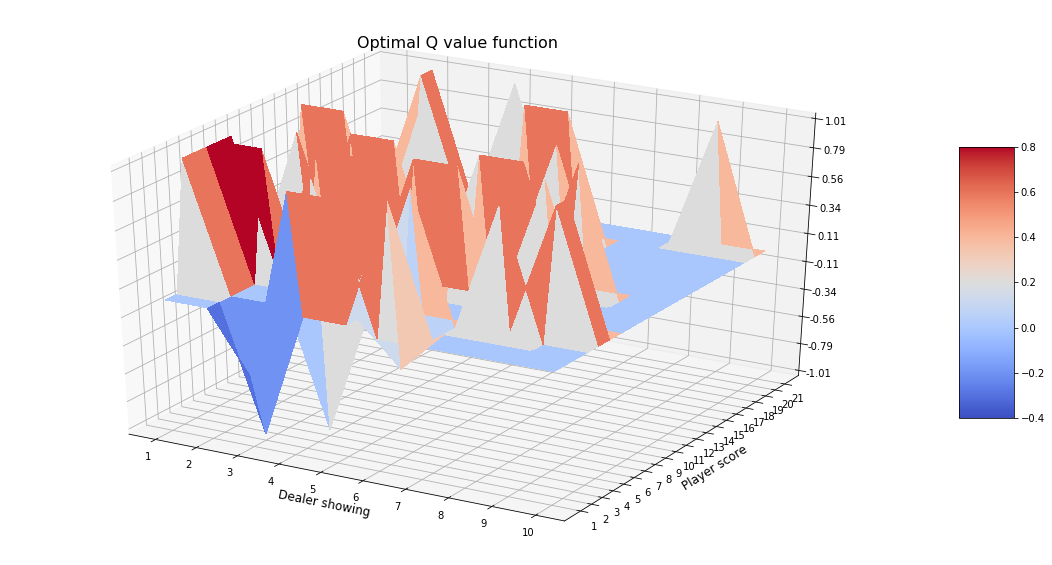

In [7]:
plot_Q(n_episodes=100)

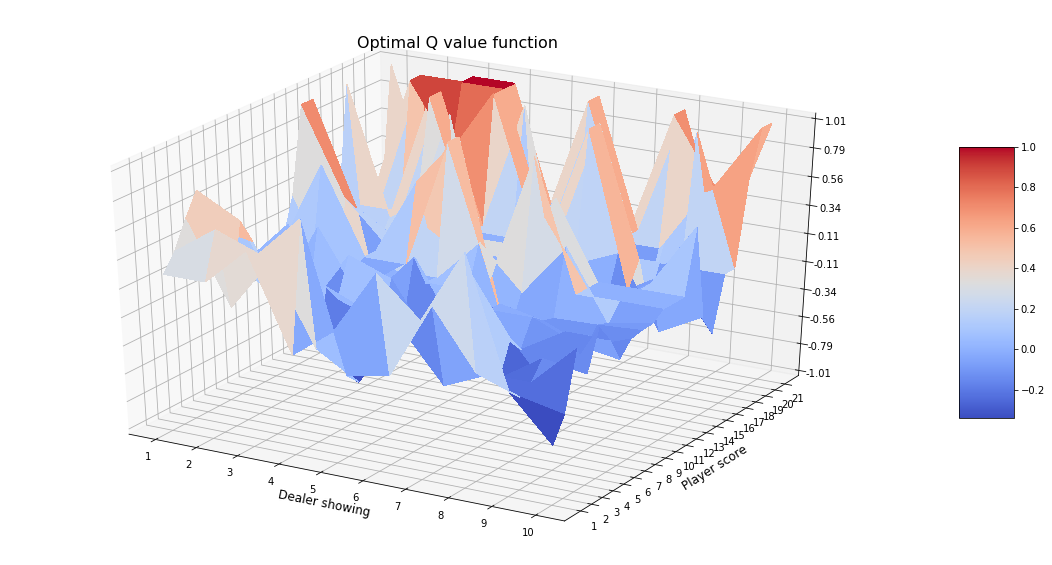

In [8]:
plot_Q(n_episodes=1000)

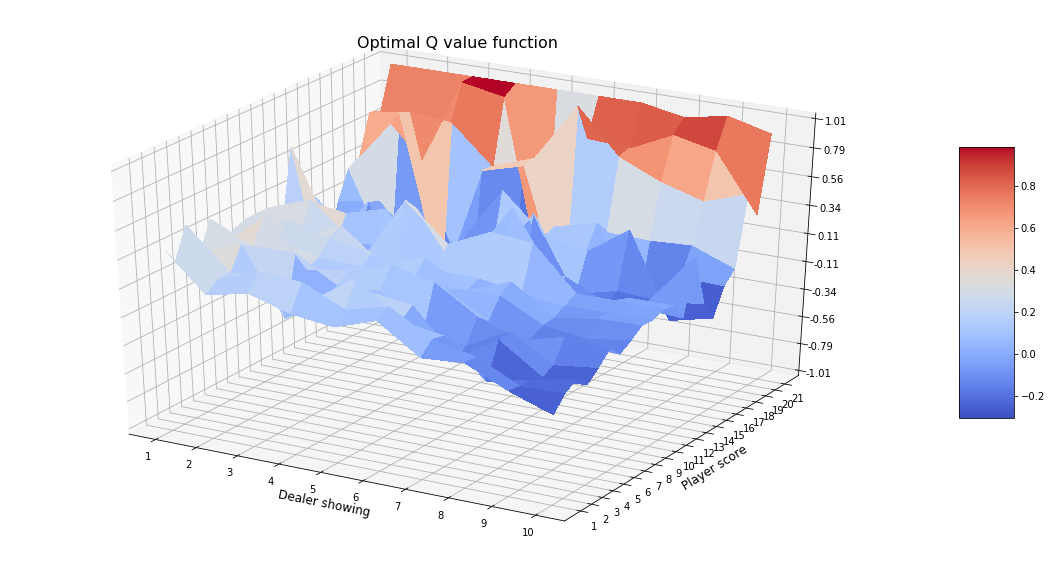

In [9]:
plot_Q(n_episodes=10000)

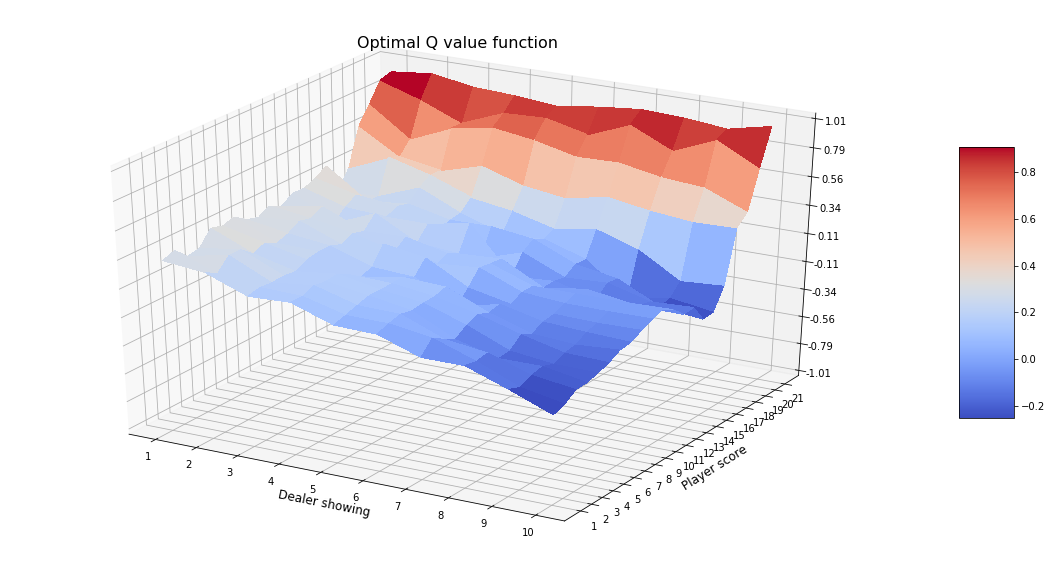

In [10]:
plot_Q(n_episodes=100000)

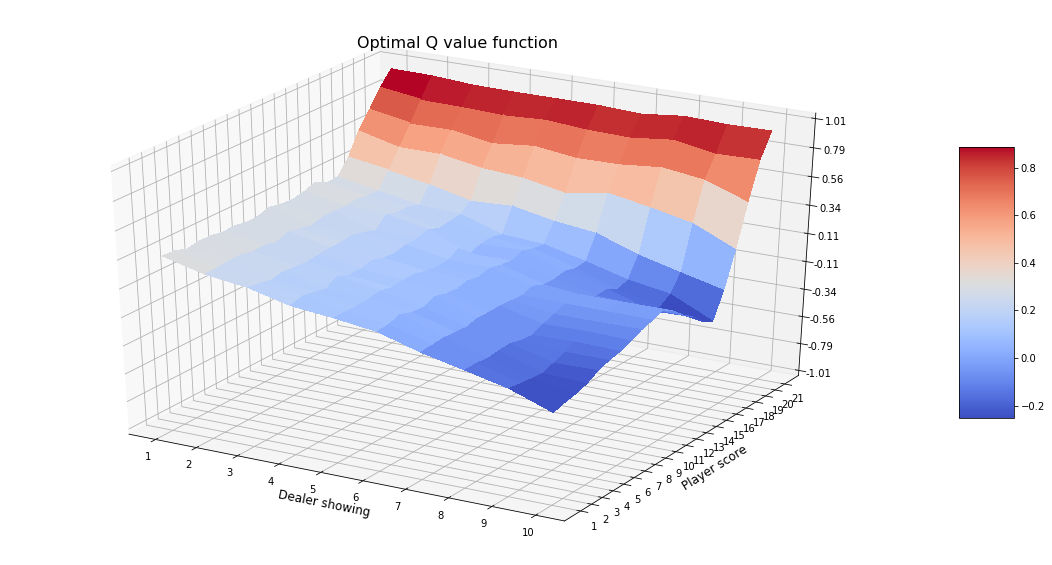

In [11]:
plot_Q(n_episodes=1000000)

In [ ]:
# Explain the graph with powerpoint 

As expected, the more sampled episodes, the less variance in the Q value function. Indeed, **sampling** methods, like Monte-Carlo are subject to high variance. The next algorithm we are going to see, SARSA(λ), which is a **bootstraping** method (we gonna see what it means) aims to relie less on the sampled episodes to calulate the optimal value function which implies lower variance.  

## Optimal policy

What's next !? 
Now that we have the optimal value function, we can build a policy upon it, the optimal policy. This optimal policy tells us what action (hit or stick) to choose in a particular state in order to maximise our potential gain!

In [12]:
def plot_opt_policy(n_episodes):
    mc = MC_Control(N_0=100, n_episodes=n_episodes)
    mc.learn_q_value_function()
    df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
    states = list(mc.Q.keys())
    for i in range(len(states)):
        best_action = max(mc.Q[states[i]], key=mc.Q[states[i]].get)
        df.loc[i] = (states[i][0], states[i][1], best_action)

    df_pivot = df.pivot("player_score", "dealer_showing", "best_action")
    return df_pivot
    

In [13]:
df = plot_opt_policy(n_episodes=1000)
df

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,hit,stick,hit,stick,hit,hit,hit,hit,stick
2,stick,stick,stick,stick,hit,hit,hit,stick,hit,hit
3,hit,stick,stick,hit,stick,stick,hit,stick,hit,hit
4,stick,hit,hit,hit,stick,stick,hit,stick,stick,stick
5,stick,hit,stick,stick,stick,stick,stick,stick,hit,hit
6,hit,stick,stick,stick,stick,hit,hit,hit,hit,hit
7,stick,stick,stick,hit,hit,stick,stick,hit,hit,hit
8,stick,stick,stick,stick,hit,stick,hit,hit,hit,hit
9,hit,hit,stick,stick,hit,hit,stick,hit,stick,hit


In [14]:
df = plot_opt_policy(n_episodes=10000)
df

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
2,stick,stick,stick,stick,stick,stick,hit,hit,hit,hit
3,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
4,stick,hit,stick,stick,stick,stick,stick,stick,hit,hit
5,stick,stick,stick,stick,stick,stick,stick,hit,stick,hit
6,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit
7,stick,stick,stick,stick,stick,stick,hit,hit,hit,hit
8,stick,stick,stick,stick,stick,hit,hit,stick,hit,hit
9,stick,stick,stick,hit,stick,hit,hit,stick,hit,hit


In [15]:
df = plot_opt_policy(n_episodes=100000)
df

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
5,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
6,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
7,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit
8,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit
9,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit


In [16]:
df = plot_opt_policy(n_episodes=1000000)
df

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
5,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit
6,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
7,stick,stick,stick,stick,stick,stick,stick,stick,hit,hit
8,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit
9,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit


# TD learning with SARSA(λ) in Easy21

# Linear Value Approximation in Easy21

# Discussion